In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["TERRA_CONFIG_PATH"] = "/home/sabri/code/spr-21/terra_config.json"

In [2]:
import pandas as pd
import torch

In [3]:
from robustnessgym.mosaic.contrib.wilds import WILDSInputColumn, WILDSDataPane
from robustnessgym.mosaic import DataPane
dp = WILDSDataPane(
    "fmow", 
    root_dir="/home/common/datasets/", 
    use_transform=True,
    split="val"
)

In [7]:
from spr.vision import Classifier
from spr.data.wilds import FMOW_CONFIG
model = Classifier(FMOW_CONFIG)

class ActivationExtractor:
    """Class for extracting activations of a targetted intermediate layer."""

    def __init__(self):
        self.activation = None

    def add_hook(self, module, input, output):
        self.activation = output

extractor = ActivationExtractor()
model.model.features[-1].register_forward_hook(extractor.add_hook);

loading weights from /home/common/datasets/fmow_v1.1/models/fmow_erm_ID_seed0/best_model.pth...
/home/common/envs/conda/envs/rg-sabri/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [21]:
model.to(0).eval()

@torch.no_grad()
def predict(batch: dict):
    out = torch.softmax(model(torch.tensor(batch["input"]).to(0)), axis=-1)
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": out.cpu().numpy(),
        "activation": extractor.activation.cpu().numpy()
    }

dp = dp.update(
    function=predict, 
    batch_size=128, 
    batched=True, 
    num_workers=4, 
    input_columns=["input"]
)

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [11]:
from spr.bss_dp import SourceSeparator

In [12]:
separator = SourceSeparator(model, config={
    "num_classes": 62, 
    "class_idx": 5,
    "activation_dim": 1024, 
    "lr": 1e-2,
    "batch_size": 256
})

In [13]:
separator.fit(dp=dp, num_epochs=3)

In [14]:
separator.to(0).eval()

@torch.no_grad()
def compute_components(batch: dict):
    components = separator.forward(torch.tensor(batch["activation"]).to(0))
    #components = components.permute((3, 0, 1, 2))
    return {"components": components.cpu().numpy()}

dp = dp.update(
    function=compute_components, 
    batch_size=128, 
    batched=True, 
    num_workers=4, 
    overwrite=True,
    input_columns=["activation"]
)

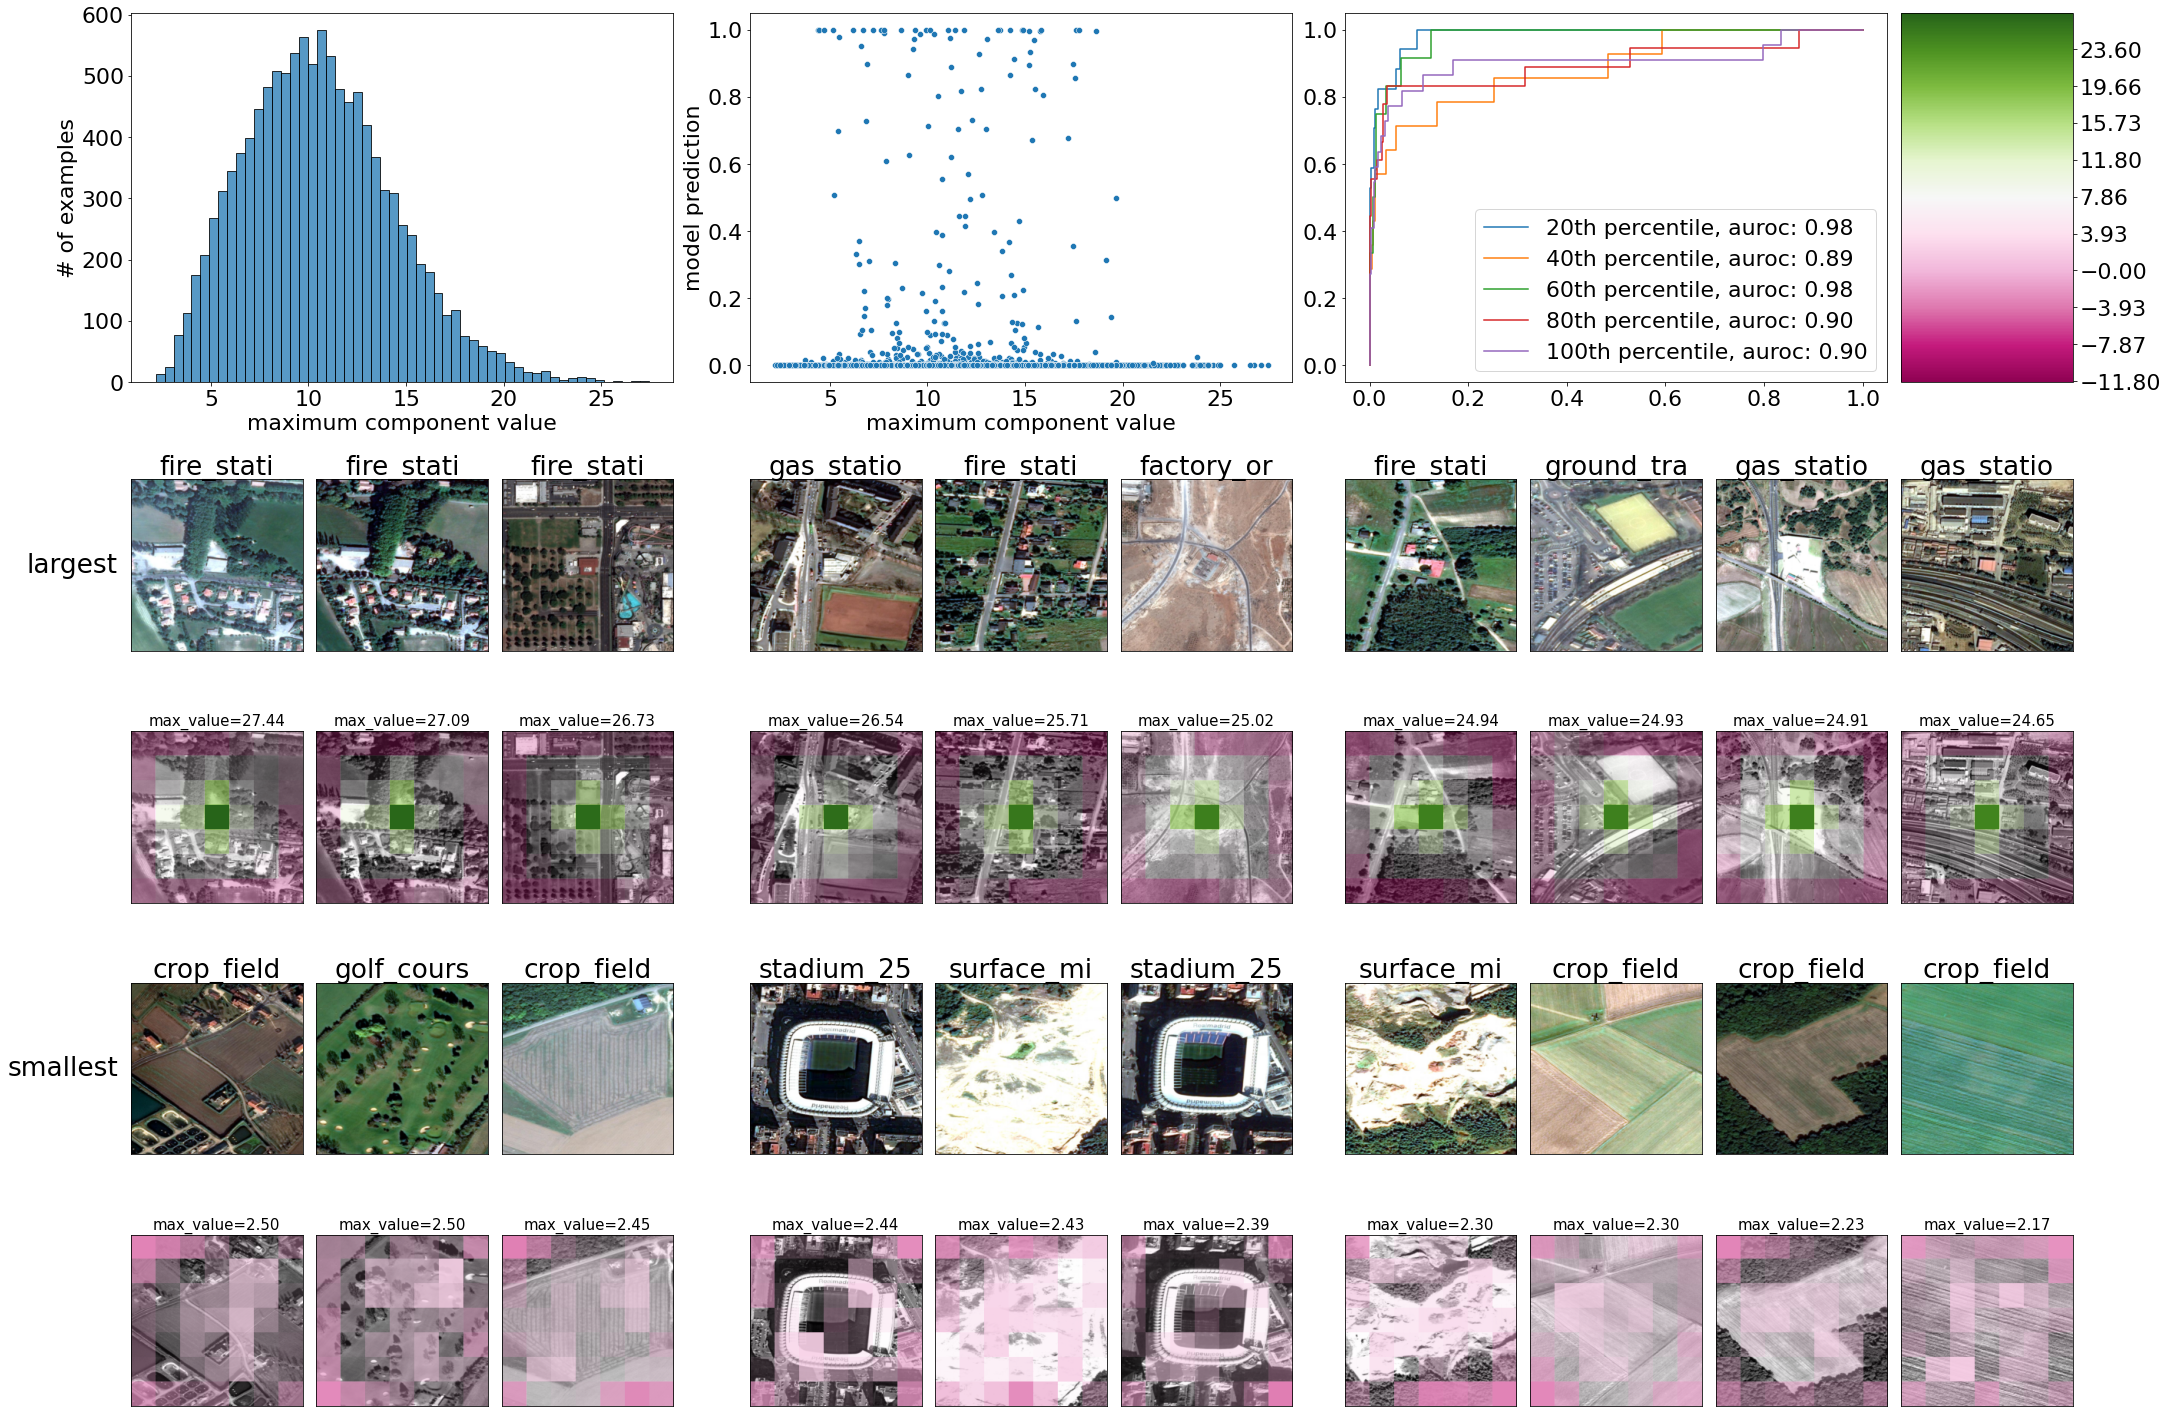

In [20]:
from spr.vis import visualize_component_dp
visualize_component_dp(
    dp=dp,
    class_idx=5,
    comp_idx=4
)

In [39]:
dp[["category", "y"]]

DataPane(num_rows: 0)

In [35]:
dp.visible_columns = dp.visible_columns + ["raw_input", "img_filename"]

In [ ]:
from spr.vis import visualize_component
from spr.vision import compute_bss

components, outs, targets = compute_bss.out(run_id=202)
visualize_component(
    data_df=df,
    components=components, 
    preds = outs, 
    targets=targets,
    split="id_valid",
    comp_idx=0,
    flip=False,
    **iwildcam_task_config
)

In [17]:
raw = dp["input"].copy()
raw._data.transform = lambda x: x

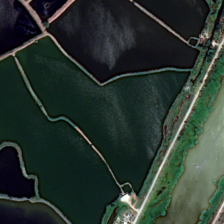

In [18]:
raw[0]

In [44]:
import gradio as gr

def greet(name):
  return "Hello " + name + "!"

iface = gr.Interface(fn=greet, inputs="text", outputs="text")
iface.launch()

Running locally at: http://127.0.0.1:7861/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7861/', None)